<a href="https://colab.research.google.com/github/kskksg4/Toonify_yourself/blob/main/Toonify_yourself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.31 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/stylegan2
CPU says hello.
GPU says hello.


In [3]:
!mkdir raw

In [4]:
!mkdir generated
!mkdir aligned

In [5]:
!wget https://upload.wikimedia.org/wikipedia/commons/8/82/Steve_Jobs_with_red_shawl_edit.jpg -O raw/example.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/f/f5/200129_%EC%A1%B0%EB%B3%B4%EC%95%84_%282%29.jpg -O raw/boa_01.jpg
!wget http://www.mhns.co.kr/news/photo/202010/418302_544162_651.jpg -O raw/boa_02.jpg

--2020-10-28 06:28:32--  https://upload.wikimedia.org/wikipedia/commons/8/82/Steve_Jobs_with_red_shawl_edit.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 529870 (517K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>] 517.45K  --.-KB/s    in 0.1s    

2020-10-28 06:28:33 (5.17 MB/s) - ‘raw/example.jpg’ saved [529870/529870]

--2020-10-28 06:28:33--  https://upload.wikimedia.org/wikipedia/commons/f/f5/200129_%EC%A1%B0%EB%B3%B4%EC%95%84_%282%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66001 (64K) [image/jpeg]
Saving to: ‘raw/boa_01.jpg’

raw/boa_01.jpg     

In [6]:
import pretrained_networks

blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, gs_blended = pretrained_networks.load_networks(blended_url)
_, _, gs = pretrained_networks.load_networks(ffhq_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [7]:
!python align_images.py raw aligned

64045056/64040097 [==============================] - 2s 0us/step


In [8]:
!python project_images.py --num-steps 1000 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "boa_01_01.png"...
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "boa_02_01.png"...
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_01.png"...


In [11]:
import numpy as np
import dnnlib
import dnnlib.tflib as tflib

from PIL import Image
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")

for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent, axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = gs_blended.components.synthesis.run(latent, randomsize_noise=False, **synthesis_kwargs)

  Image.fromarray(images.transpose((0, 2, 3, 1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))

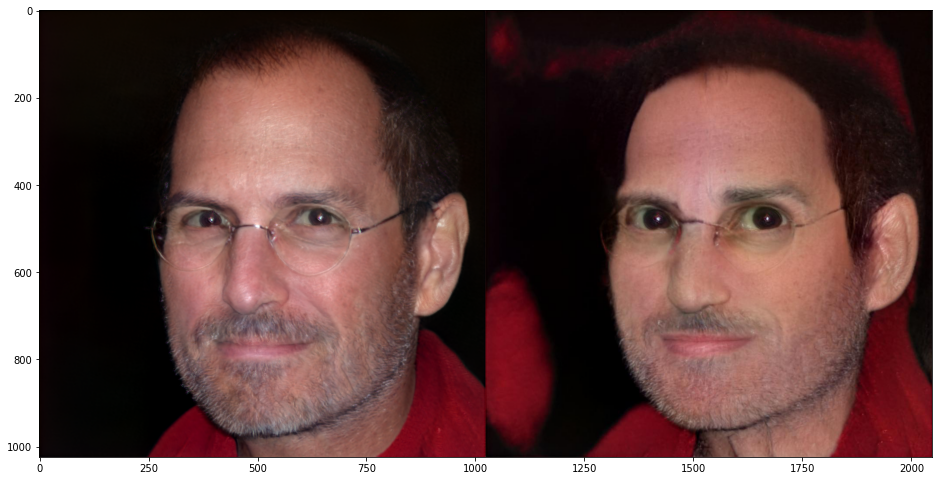

In [12]:
import matplotlib.pyplot as plt

embedded = Image.open("generated/example_01.png")
tooned = Image.open("generated/example_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))

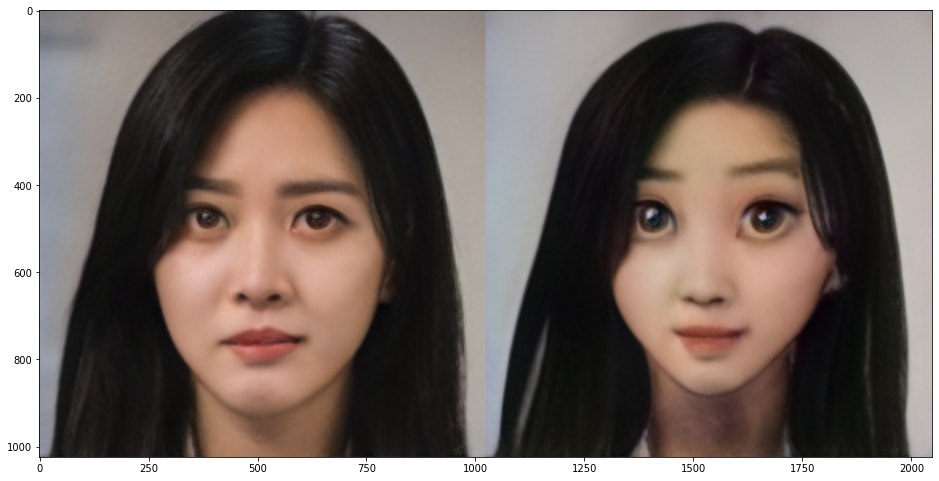

In [15]:
embedded = Image.open("generated/boa_02_01.png")
tooned = Image.open("generated/boa_02_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))